In [1]:
import os
import subprocess
import random
from tqdm import tqdm                        # Import tqdm for progress bars
import inspect
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt              # For plotting
import seaborn as sns                        # For styling plots

from PIL import Image

import timm                                  # for using pre-trained models such as EfficientNet, ViT


# Pytorch
import torch                                 # Overall PyTorch import
import torch.optim as optim                  # For optimizizing model parameters
import torch.nn as nn                        # For specifying neural networks
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms  # For pre-processing data

c:\Users\Public\anaconda3\envs\SFAI\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
# torch.backends.mps.is_available()
torch.cuda.is_available()

True

In [20]:
points = np.logspace(0, np.log10(0.5), 10)
print(1 - points)

[0.         0.07412529 0.14275602 0.20629947 0.26513275 0.319605
 0.37003948 0.41673548 0.45997013 0.5       ]


### Define Configuration

In [8]:
class Config:
    # Reproducibility
    SEED = 42

    # Model Hyperparameters
    model_name = 'vit'                 # 'restnet152', 'efficientnet_{b0, b1, ... , b7}', 'vit'
    _in_channels = 3                   # RGB images
    image_res = 64                     # Must be multiple of 256
    num_classes = 200
    _efficientnet_model_name = 'efficientnet_b5'
    pretrained_efficient_net = True
    # if model_name != 'vit' and model_name != 'resnet152' and int(model_name.split('_b')[-1]) >= 5:
    #     pretrained_efficient_net = False
    use_batchNorm = False
    dropout_rate = 0                   # 0, 0.1, 0.5
    l2_regularization_strength = 0     # 0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7
    batch_size = 128                   # change batch size to fit memory budget, set to 2 here for contrastive loss
    learning_rate = 1e-5               # 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7
    epochs = 1

    # Loss
    use_contrastive = False
    lambda_contrastive = 10            # 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7

    # Data Paths
    _data_path = os.path.join(os.getcwd(), 'data')
    dataset = 'tiny-imagenet-200'
    _ds_path = os.path.join(_data_path, dataset)
    _data_csv_path = os.path.join(_ds_path, 'tinyimagenet.csv')

    # Saving Paths
    _result_dir = "results"
    _weight_dir = "weights"
    if not os.path.exists(_result_dir):
        os.makedirs(_result_dir)
    if not os.path.exists(_weight_dir):
        os.makedirs(_weight_dir)
    
    # File Names and Paths
    _model_fname = f"best_{model_name}_lr-{learning_rate}_dropout_rate-{dropout_rate}_batchNorm-{use_batchNorm}"
    _save_result_path = os.path.join(_result_dir, _model_fname)
    _save_weight_path = os.path.join(_weight_dir, _model_fname)
    _dict = {}

config = Config()

### Construct Data Frame

In [10]:
if os.path.exists(config._data_csv_path):
    print('Loading existing data csv file')
    df = pd.read_csv(config._data_csv_path)
else:
    print('Creating data csv file')
    # specify the data path
    data_path = config._ds_path

    # Specify the words file name
    words_file_path = os.path.join(data_path, "words.txt")

    # Read data from the file
    with open(words_file_path, 'r') as file:
        words = file.read()

    # Split the data into lines
    lines = words.split('\n')

    # Construct the dictionary
    label2text = {}
    for line in lines:
        if line:
            key, value = line.split(maxsplit=1)
            label2text[key] = value

    # Print the resulting dictionary
    train_dir = os.path.join(data_path, 'train')
    val_dir = os.path.join(data_path, 'val')
    dirs = {'train': train_dir, 'val': val_dir}

    data_list = []
    for ds, ds_path in dirs.items():
        for label in os.listdir(ds_path):
            label_dir = os.path.join(ds_path, label)
            if os.path.isdir(label_dir):
                for image_path in os.listdir(label_dir):
                    if not image_path.split('.')[-1] == 'JPEG':
                        continue
                    image_path = os.path.join(label_dir, image_path)
                    data_list.append({
                    'image_path': image_path,
                    'set': ds,
                    'label': label,
                    'label-description': label2text[label]
                    })
    df = pd.DataFrame(data_list)
    df.to_csv(config._data_csv_path, index=False)
df.sample(n=5).head()

Loading existing data csv file


,image_path,set,label,label-description
102043,c:\Users\Ciel Sun\Desktop\EE 562 AI_For_Engine...,val,n02231487,"walking stick, walkingstick, stick insect"
13652,c:\Users\Ciel Sun\Desktop\EE 562 AI_For_Engine...,train,n02099712,Labrador retriever
31289,c:\Users\Ciel Sun\Desktop\EE 562 AI_For_Engine...,train,n02730930,apron
84215,c:\Users\Ciel Sun\Desktop\EE 562 AI_For_Engine...,train,n04507155,umbrella
42205,c:\Users\Ciel Sun\Desktop\EE 562 AI_For_Engine...,train,n02950826,cannon


### Investigate Dataset

Count of training images: 100000
Count of validation images: 10000
Total number of images: 110000
Train test split ratio: 0.9 :    0.1
num_unique_labels = 200


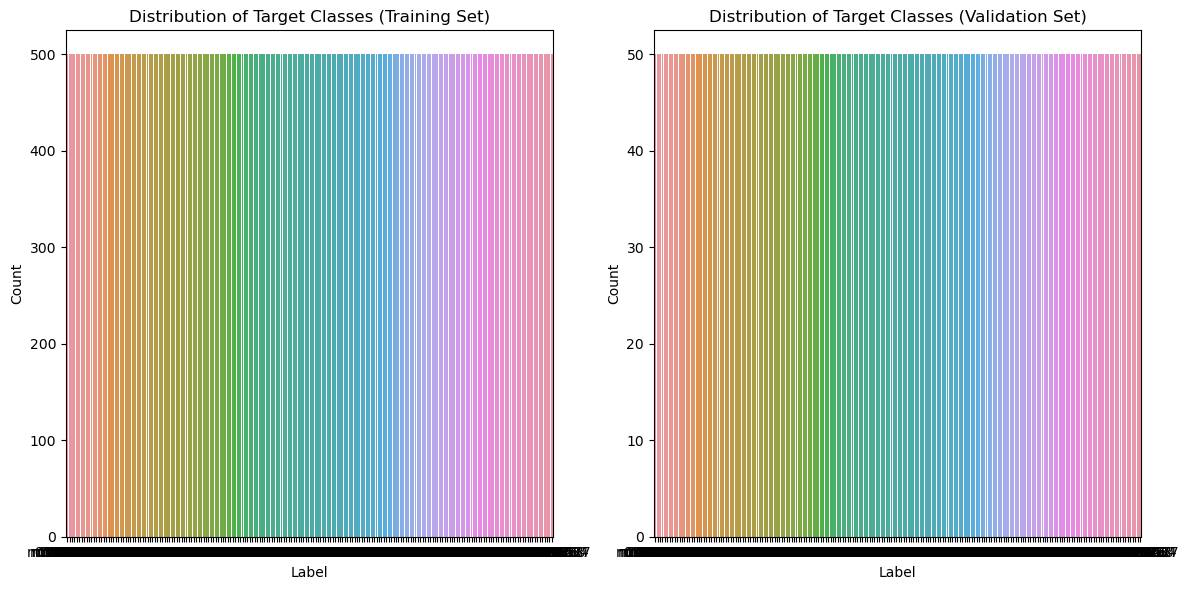

Class imbalance ratio: 1.0


In [11]:
def visualize_ds(df):
    # Get basic statistics about the dataset
    train_count = df['set'].value_counts().get('train', 0)
    val_count = df['set'].value_counts().get('val', 0)
    num_unique_labels = df['label'].nunique()
    unique_labels = df['label'].unique()
    label_counts = df['label'].value_counts()
    # Get the counts for the least and most common labels
    least_common_count = label_counts.min()
    most_common_count = label_counts.max()
    imb_ratio = least_common_count / most_common_count
    print("Count of training images:", train_count)
    print("Count of validation images:", val_count)
    print(f"Total number of images: {train_count + val_count}")
    print(f"Train test split ratio: {train_count/(train_count + val_count):.1f} :\
    {val_count/(train_count + val_count):.1f}")
    print(f"{num_unique_labels = }")

    # Plot the distribution of the target classes for both training and validation sets
    plt.figure(figsize=(12, 6))

    # Training set
    plt.subplot(1, 2, 1)
    sns.countplot(data=df[df['set'] == 'train'], x='label', order=df['label'].value_counts().index)
    plt.title('Distribution of Target Classes (Training Set)')
    plt.xlabel('Label')
    plt.ylabel('Count')

    # Validation set
    plt.subplot(1, 2, 2)
    sns.countplot(data=df[df['set'] == 'val'], x='label', order=df['label'].value_counts().index)
    plt.title('Distribution of Target Classes (Validation Set)')
    plt.xlabel('Label')
    plt.ylabel('Count')

    plt.tight_layout()
    plt.show()

    print(f"Class imbalance ratio: {imb_ratio}")

visualize_ds(df)

### Data Visualization

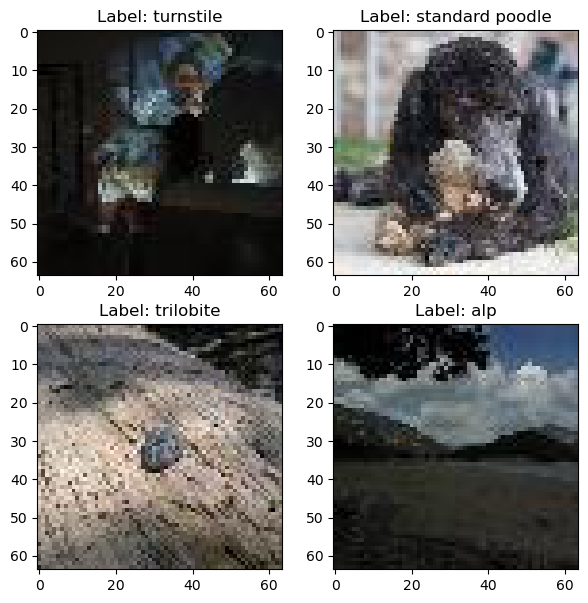

In [12]:
random.seed(config.SEED)
random_indices = random.sample(range(len(df)), 4)
# Plot the images with increased spacing
plt.figure(figsize=(7, 7))
for i, index in enumerate(random_indices, 1):
    plt.subplot(2, 2, i)
    plt.imshow(plt.imread(df['image_path'].iloc[index]))
    plt.title(f"Label: {df['label-description'].iloc[index]}")

plt.show()

### Perform one-hot encoding


In [13]:
# Perform one-hot encoding on the 'label' column
df_one_hot = pd.get_dummies(df["label"], prefix="label").astype(int)

# Extract columns from the original DataFrame excluding 'label'
exclude_columns = ['label']
additional_columns = df[[col for col in df.columns if col not in exclude_columns]]

# Concatenate the original DataFrame with the one-hot encoded labels
df_combined = pd.concat([df_one_hot, additional_columns], axis=1)

### Create a Pytorch Data Loading Pipeline

In [14]:
# Custom dataset class for loading images and corresponding labels
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        """
        Args:
            image_paths (list): List of file paths to the images.
            labels (list): List of corresponding labels.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # Returns the total number of samples in the dataset
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample.

        Returns:
            tuple: (image, label) where image is a PyTorch tensor and label is an integer.
        """
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        # Read and preprocess the image
        with open(image_path, 'rb') as f:
            image = Image.open(f).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [15]:
# labels = df[[col for col in df.columns if col.startswith("label_")]].values
train_labels = df_combined[df_combined['set'] == 'train'][[col for col in df_combined.columns if col.startswith("label_")]].values
val_labels = df_combined[df_combined['set'] == 'val'][[col for col in df_combined.columns if col.startswith("label_")]].values
train_paths = df_combined[df_combined['set'] == 'train']['image_path'].values
val_paths = df_combined[df_combined['set'] == 'val']['image_path'].values

assert(len(train_labels) == len(train_paths))
assert(len(val_labels) == len(val_paths))

# Define transformations
transform = transforms.Compose([
    transforms.Resize((config.image_res, config.image_res)),
    # transforms.Resize((config.image_res, config.image_res)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # TODO: add other transformations...
])

# Create custom datasets
train_dataset = CustomDataset(train_paths, train_labels, transform=transform)
val_dataset = CustomDataset(val_paths, val_labels, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)

### Build Models

In [16]:
class ResNet152(nn.Module):
    def __init__(self, in_channels, num_classes, dropout_prob=0.5):
        """
        Initializes the ResNet152 model with drop out regularization.

        Args:
            in_channels (int): Number of input channels.
            num_classes (int): Number of output classes.
            dropout_prob (float): Dropout probability. Set to 0 to disable dropout.
        """
        super(ResNet152, self).__init__()

        # Initial convolution block
        self.conv1 = conv_block(in_channels, 64)
        # Downsample with pooling
        self.conv2 = conv_block(64, 128, pool=True, dropout_prob=dropout_prob)
        # Residual blocks
        self.res1 = nn.Sequential(conv_block(128, 128, dropout_prob=dropout_prob),
                                  conv_block(128, 128, dropout_prob=dropout_prob))

        self.conv3 = conv_block(128, 256, pool=True, dropout_prob=dropout_prob)
        self.conv4 = conv_block(256, 512, pool=True, dropout_prob=dropout_prob)
        self.res2 = nn.Sequential(conv_block(512, 512, dropout_prob=dropout_prob),
                                  conv_block(512, 512, dropout_prob=dropout_prob))

        self.conv5 = conv_block(512, 1028, pool=True, dropout_prob=dropout_prob)
        self.res3 = nn.Sequential(conv_block(1028, 1028, dropout_prob=dropout_prob),
                                  conv_block(1028, 1028, dropout_prob=dropout_prob))

        # Embedding extract
        self.emb_ext = nn.Linear(int(65792 * (config.image_res / 256)**2), 256)

        # Classifier
        self.classifier_pre = nn.Sequential(nn.MaxPool2d(2), nn.Flatten())
        self.classifier = nn.Linear(int(65792 * (config.image_res / 256)**2), num_classes)

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        res1_out = self.res1(out) + out

        out = self.conv3(res1_out)
        out = self.conv4(out)
        res2_out = self.res2(out) + out

        out = self.conv5(res2_out)
        res3_out = self.res3(out) + out
        out = self.classifier_pre(res3_out)
        # emb = self.emb_ext(out)
        out = self.classifier(out)
        # return out, emb
        return out

def conv_block(in_channels, out_channels, pool=False, dropout_prob=0.5):
    """
    Defines a convolutional block with optional max pooling and dropout.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        pool (bool): Whether to include max pooling after convolution.
        dropout_prob (float): Dropout probability. Set to 0 to disable dropout.

    Returns:
        nn.Sequential: A sequential module representing the convolutional block.
    """
    layers = []
    layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
    layers.append(nn.BatchNorm2d(out_channels))
    layers.append(nn.ReLU(inplace=True))

    # Add dropout layer with the specified probability
    if dropout_prob > 0:
        layers.append(nn.Dropout2d(p=dropout_prob))

    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

def build_efficientnet(in_channels=3, num_classes=200):
    model = timm.create_model(config._efficientnet_model_name, pretrained=config.pretrained_efficient_net, in_chans=in_channels)
    # Modify the classifier to match the number of classes
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    return model

class CustomViT(nn.Module):
    def __init__(self, cfg):
        super(CustomViT, self).__init__()
        # self.model = timm.create_model('vit_base_patch16_224', pretrained=False, **cfg)
        self.model = timm.create_model('vit_base_patch16_224', pretrained=True, **cfg)

    def forward(self, x):
        return self.model(x)

'''class VisionTransformer(nn.Module):
    def __init__(self, model_name='vit_base_patch16_224', num_classes=200, pretrained=True):
        super(VisionTransformer, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        in_features = self.model.head.in_features
        self.model.head = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)'''

"""class CustomViT(nn.Module):
    def __init__(self, model_name='vit_base_patch16_224', num_classes=200, in_channels=3, input_size=(config.image_res, config.image_res)):
        super(CustomViT, self).__init__()

        # Load pre-trained ViT model
        self.model = timm.create_model(model_name, pretrained=True)

        # Adjust the first layer to match the desired input channels and size
        if in_channels != 3 or input_size != (224, 224):
            # Calculate the new number of patches
            num_patches_h = input_size[0] // self.model.patch_embed.patch_size[0]   # 64 // 16 = 4
            num_patches_w = input_size[1] // self.model.patch_embed.patch_size[1]   # 64 // 16 = 4

            # Modify the patch embedding layer
            self.model.patch_embed = nn.Conv2d(
                in_channels, self.model.patch_embed.num_patches,
                kernel_size=self.model.patch_embed.patch_size,
                stride=(num_patches_h, num_patches_w)
            )

        # Modify the classifier to match the number of classes
        in_features = self.model.head.in_features
        self.model.head = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)"""

"class CustomViT(nn.Module):\n    def __init__(self, model_name='vit_base_patch16_224', num_classes=200, in_channels=3, input_size=(config.image_res, config.image_res)):\n        super(CustomViT, self).__init__()\n\n        # Load pre-trained ViT model\n        self.model = timm.create_model(model_name, pretrained=True)\n\n        # Adjust the first layer to match the desired input channels and size\n        if in_channels != 3 or input_size != (224, 224):\n            # Calculate the new number of patches\n            num_patches_h = input_size[0] // self.model.patch_embed.patch_size[0]   # 64 // 16 = 4\n            num_patches_w = input_size[1] // self.model.patch_embed.patch_size[1]   # 64 // 16 = 4\n\n            # Modify the patch embedding layer\n            self.model.patch_embed = nn.Conv2d(\n                in_channels, self.model.patch_embed.num_patches,\n                kernel_size=self.model.patch_embed.patch_size,\n                stride=(num_patches_h, num_patches_w)\n   

### Load Model

In [17]:
in_channels = config._in_channels  # Assuming RGB images
num_classes = config.num_classes  # Adjust as needed
dropout_rate = config.dropout_rate  # Adjust as needed
print(f"Training a {config.model_name} model")
if config.model_name == 'resnet152':
    model = ResNet152(in_channels, num_classes, dropout_prob = config.dropout_rate)
elif config.model_name.split('_')[0] == 'efficientnet':
    model = build_efficientnet()
elif config.model_name == 'vit':
    custom_cfg = {
    'img_size': config.image_res,
    'patch_size': 16,
    'in_chans': config._in_channels,
    'num_classes': config.num_classes,
    # Add other configuration options as needed
    }
    model = CustomViT(cfg=custom_cfg)
print(model)

Training a vit model
CustomViT(
  (model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(a

### Helper Functions

In [50]:
def accuracy(net, data_loader, task=None):
    """
    For a given data_loader, evaluate the model on the dataset and compute its classification
    accuracy.

    Args:
        net: The neural network to train
        data_loader: A dataset loader for some dataset.
    Returns:
        The classificiation accuracy of the model on this dataset.
    """
    correct = 0
    total = 0
    # TODO: add tqdm for evaluation loop
    # for images, labels in data_loader:
    for images, labels in tqdm(data_loader, desc=f"Evaluating {task} accuracy", unit="batch", leave=False):
        if  torch.cuda.is_available():
            net = net.cuda()
            images = images.cuda()
            labels = labels.cuda()

        # if torch.backends.mps.is_available():
        #     mps_device = torch.device("mps")
        #     net.to(mps_device)
        #     images, labels = images.to(mps_device), labels.to(mps_device)

        outputs = net(images)                           # Make predictions
        _, predicted = torch.max(outputs.data, 1)       # Choose class with highest scores
        _, labels = torch.max(labels, 1)

        total += labels.size(0)                         # Increment the total count
        correct += (predicted == labels).sum().item()   # Increment the correct count
    return correct / total

def plot_loss(Loss):
    plt.figure(figsize=(10,8))
    epochs = list(range(1, len(Loss) + 1))
    plt.plot(epochs, Loss, label=' Loss')
    plt.xlabel('Iter')
    plt.ylabel('Loss')
    plt.legend()
    plt.xlim([1,max(epochs)])
    ''' !!!!! Change the plot title every time accordingly, or change the title and then
    re-run the plot history function at the end of training !!!!!'''
    plt.title(f'Loss records with Epoch={config.epochs}')

def plot_history(history):
    """
    Given a series of training/test accuracies from training, plots them to visualize learning.

    Args:
        history: A dictionary storing information about the model trained.
        It should have the keys:
            * train_accs: A list of train accuracies
            * test_accs: A list of test accuracies.
    """
    plt.figure()
    epochs = list(range(1, len(history['train_accs']) + 1))
    val = plt.plot(epochs, history['val_accs'],
                     '--', label=' Test')
    plt.plot(epochs, history['train_accs'], color=val[0].get_color(),
               label=' Train')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xlim([1,max(epochs)])
    # Force x-axis ticks to be integers
    plt.xticks(list(epochs))
    plt.title(f'Accuracy results with Epoch={config.epochs}')

def save_plot(json_file):
    result_folder = "results"
    if not os.path.exists(result_folder):
        os.makedirs(result_folder)
    
    plt.figure()
    # Read JSON data from file
    with open(json_file, 'r') as file:
        json_data = json.load(file)

    # Extracting data
    epochs = range(1, json_data["Num-Epochs"] + 1)
    train_accs = json_data["train_accs"]
    val_accs = json_data["val_accs"]

    # Plotting
    plt.plot(epochs, train_accs, label='Train Accuracy')
    plt.plot(epochs, val_accs, label='Validation Accuracy')
    plt.title('Training and Validation Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    # Set y-axis limit to 1
    plt.ylim(0, 1)
    # Force x-axis ticks to be integers
    plt.xticks(list(epochs))

    # Save the plot to a JPG file with the same name as the JSON file
    jpg_file = json_file.replace('.json', '.jpg')
    plt.savefig(jpg_file)

    # Close the plot without displaying it
    plt.close()

def train_loop(model, train_loader, val_loader, config):
    if torch.cuda.is_available():
        model = model.cuda()

    # if torch.backends.mps.is_available():
    #     mps_device = torch.device("mps")
    #     model.to(mps_device)

    classification_criterion = nn.CrossEntropyLoss()
    # if config.use_contrastive:
    #     contrastive_criterion = ContrastiveLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate,
                          weight_decay=config.l2_regularization_strength)

    train_accs = []
    val_accs = []
    losses = []
    best_val_acc = 0.0  # Initialize the best validation accuracy
    best_epoch = 0      # Initialize the epoch where the best accuracy occurred

    for epoch in range(1, config.epochs + 1):
        model.train()
        total_batches = len(train_loader)
        train_loader_with_progress = tqdm(train_loader, total=total_batches, desc=f'Epoch {epoch}/{config.epochs}')

        for inputs, labels in train_loader_with_progress:
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()

            # if torch.backends.mps.is_available():
            #     mps_device = torch.device("mps")
            #     inputs, labels = inputs.to(mps_device), labels.to(mps_device)

            optimizer.zero_grad()
            outputs = model(inputs)
            # print(f'Outputs shape: {outputs.shape}')
            # print(f'Labels shape: {labels.shape}')
            # print(f'Embeddings shape: {embs.shape}')

            # Compute the classification loss
            classification_loss = classification_criterion(outputs.float(), labels.float())
            total_loss = classification_loss

            # # Compute the contrastive loss
            # if config.use_contrastive and len(embs) == 2:
            #     positive_emb, negative_emb = embs[0], embs[1]
            #     contrastive_labels = labels[1]  # Assuming labels[1] contains the contrastive labels
            #     contrastive_loss = contrastive_criterion(positive_emb, negative_emb, contrastive_labels.float(), dist='cosine')

            #     # Combine the losses (you can adjust the weights as needed)
            #     total_loss += config.lambda_contrastive * contrastive_loss


            # continue
            total_loss.backward()
            optimizer.step()

            losses.append(total_loss.item())
        # continue
        model.eval()
        # print("Evaluating training accuracy")
        train_acc = accuracy(model, train_loader, task='training')
        # print("Evaluating validation accuracy")
        val_acc = accuracy(model, val_loader, task='validaiton')
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f'Epoch [{epoch}/{config.epochs}], Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}, Loss: {total_loss:.4f}')

        # Check if the current model has the best validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch

            # Save the model weights
            torch.save(model.state_dict(), f'{config._save_weight_path}.pth')

    print(f'Best Validation Accuracy of {best_val_acc:.4f} achieved at Epoch {best_epoch}')
    return train_accs, val_accs, losses


### Train the model

In [31]:
train_accs, val_accs, losses = train_loop(model, train_loader, val_loader, config)

Epoch 1/10: 100%|██████████| 782/782 [14:40<00:00,  1.13s/it]


Epoch [1/10], Train Accuracy: 0.0189, Val Accuracy: 0.0190, Loss: 5.2391


Epoch 2/10: 100%|██████████| 782/782 [02:11<00:00,  5.93it/s]


Epoch [2/10], Train Accuracy: 0.1694, Val Accuracy: 0.1572, Loss: 3.9073


Epoch 3/10: 100%|██████████| 782/782 [02:11<00:00,  5.96it/s]


Epoch [3/10], Train Accuracy: 0.2624, Val Accuracy: 0.2332, Loss: 3.8088


Epoch 4/10: 100%|██████████| 782/782 [02:11<00:00,  5.95it/s]


Epoch [4/10], Train Accuracy: 0.3219, Val Accuracy: 0.2791, Loss: 2.6263


Epoch 5/10: 100%|██████████| 782/782 [02:10<00:00,  6.00it/s]


Epoch [5/10], Train Accuracy: 0.3722, Val Accuracy: 0.3199, Loss: 2.8504


Epoch 6/10: 100%|██████████| 782/782 [02:08<00:00,  6.08it/s]


Epoch [6/10], Train Accuracy: 0.4168, Val Accuracy: 0.3505, Loss: 3.3064


Epoch 7/10: 100%|██████████| 782/782 [02:08<00:00,  6.08it/s]


Epoch [7/10], Train Accuracy: 0.4513, Val Accuracy: 0.3694, Loss: 1.9204


Epoch 8/10: 100%|██████████| 782/782 [02:08<00:00,  6.08it/s]


Epoch [8/10], Train Accuracy: 0.4850, Val Accuracy: 0.3893, Loss: 2.5894


Epoch 9/10: 100%|██████████| 782/782 [02:08<00:00,  6.07it/s]


Epoch [9/10], Train Accuracy: 0.5120, Val Accuracy: 0.3990, Loss: 2.2085


Epoch 10/10: 100%|██████████| 782/782 [02:11<00:00,  5.93it/s]


Epoch [10/10], Train Accuracy: 0.5415, Val Accuracy: 0.4088, Loss: 1.8157
Best Validation Accuracy of 0.4088 achieved at Epoch 10


### Visualize and Save Results

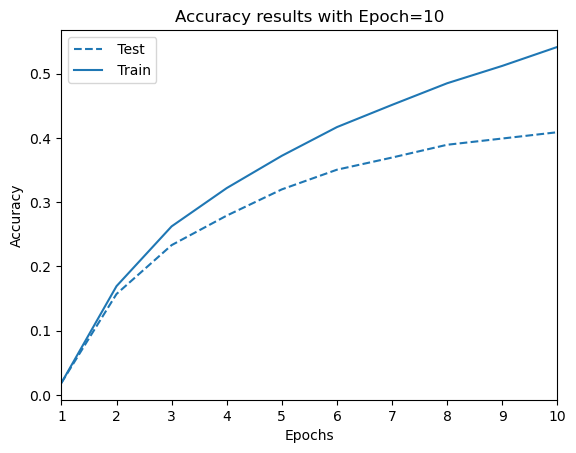

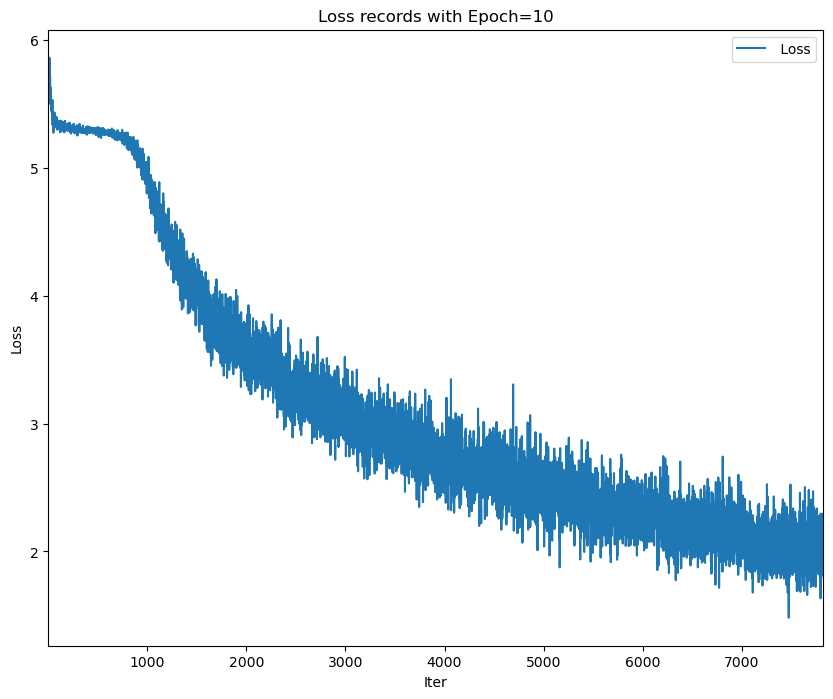

In [51]:
history = {}
# Add config values to the history dictionary
for i in inspect.getmembers(config):
    # to remove private and protected
    # functions
    if not i[0].startswith('_'):
        # To remove other methods that
        # doesnot start with a underscore
        if not inspect.ismethod(i[1]):
            key, value = i
            config._dict[key] = value
history['config'] = config._dict
history['train_accs'] = train_accs
history['val_accs'] = val_accs
history['Num-Epochs'] = len(history['val_accs'])
plot_history(history)
plot_loss(losses)

# Save json and plot
with open(config._save_result_path+".json", 'w') as json_file:
    json.dump(history, json_file)
save_plot(config._save_result_path+".json")


In [33]:
config._dict

{'SEED': 42,
 'batch_size': 128,
 'dropout_rate': 0,
 'epochs': 10,
 'image_res': 64,
 'l2_regularization_strength': 0,
 'lambda_contrastive': 10,
 'learning_rate': 1e-06,
 'model_name': 'vit',
 'num_classes': 200,
 'pretrained_efficient_net': True,
 'use_batchNorm': False,
 'use_contrastive': False}

In [34]:
print(losses)

[5.570004463195801, 5.83659553527832, 5.597344398498535, 5.80118465423584, 5.7494096755981445, 5.610152721405029, 5.7860612869262695, 5.695777416229248, 5.716836929321289, 5.683690071105957, 5.7695207595825195, 5.656756401062012, 5.6473188400268555, 5.860445022583008, 5.6198906898498535, 5.5436201095581055, 5.694214820861816, 5.570012092590332, 5.668633460998535, 5.712961196899414, 5.713274955749512, 5.589722633361816, 5.556619644165039, 5.628350257873535, 5.59493350982666, 5.495850563049316, 5.544571876525879, 5.497535705566406, 5.59627628326416, 5.490353107452393, 5.509029388427734, 5.48734188079834, 5.52071475982666, 5.4512152671813965, 5.442059516906738, 5.521451950073242, 5.5116376876831055, 5.521026134490967, 5.412448883056641, 5.400509834289551, 5.377255439758301, 5.428388595581055, 5.401427268981934, 5.530097007751465, 5.462591171264648, 5.333993911743164, 5.395171165466309, 5.43431282043457, 5.3859968185424805, 5.397676944732666, 5.3732404708862305, 5.4101152420043945, 5.38474